In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
df_user = pd.read_csv("takehome_users.csv", encoding = "ISO-8859-1")
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
df_user_suummary = pd.read_csv("takehome_user_engagement.csv")
df_user_suummary.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
df_user.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [5]:
df_user_suummary.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [6]:
df_user.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [7]:
df_user_suummary.isna().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

I'm going to guess that the adopted user are the ones that have been invited by a friend/coworker/colleague at least the majority of adopted users come from here. Let's investigate the data and test this idea.

In [8]:
df_user.rename(columns={'object_id':'user_id'}, inplace=True)

In [9]:
df_user.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

In [10]:
df_merged = df_user.merge(df_user_suummary, how='left', on='user_id')
df_merged.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-15 03:45:04,1.0
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-29 03:45:04,1.0
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-09 03:45:04,1.0
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-25 03:45:04,1.0


In [11]:
df_merged.isna().sum()

user_id                           0
creation_time                     0
name                              0
email                             0
creation_source                   0
last_session_creation_time     3177
opted_in_to_mailing_list          0
enabled_for_marketing_drip        0
org_id                            0
invited_by_user_id            92566
time_stamp                     3177
visited                        3177
dtype: int64

In [12]:
df_merged.shape

(211094, 12)

Ok this is interesting already it appears that for our merged dataset that we have null values for invited by user id last session creation time timestamp and visited blank. I can understand invited feature having missing values since not everyone that comes to this platform neccessarily got invited. From the looks of it this field is missing the most. Let's see if we can do some feature engineering/imputation first to make sure we can view the data approriately via EDA.

In [13]:
df_merged.dtypes

user_id                         int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
time_stamp                     object
visited                       float64
dtype: object

I think of top we can remove the name column I don't believe certain names or ids have a propensity to adopt the platform.

In [14]:
df_feat_subset = df_merged.loc[:, ~df_merged.columns.isin(['name'])]

In [15]:
df_feat_subset.head()

,user_id,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited
0,1,2014-04-22 03:53:30,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,1.0
1,2,2013-11-15 03:45:04,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-15 03:45:04,1.0
2,2,2013-11-15 03:45:04,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-29 03:45:04,1.0
3,2,2013-11-15 03:45:04,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-09 03:45:04,1.0
4,2,2013-11-15 03:45:04,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-25 03:45:04,1.0


In [16]:
df_feat_subset.shape

(211094, 11)

In [17]:
df_feat_subset.dtypes

user_id                         int64
creation_time                  object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
time_stamp                     object
visited                       float64
dtype: object

In [18]:
df_feat_subset['creation_time'].describe()

count                  211094
unique                  11996
top       2012-06-25 14:34:33
freq                      606
Name: creation_time, dtype: object

In [19]:
def _convert_to_timestamp(attr):
    return pd.Timestamp(attr).timestamp() if pd.notnull(attr) else -1
df_feat_subset['creation_ts'] = df_feat_subset['creation_time'].apply(_convert_to_timestamp)

In [20]:
df_feat_subset['creation_ts']

0         1.398139e+09
1         1.384487e+09
2         1.384487e+09
3         1.384487e+09
4         1.384487e+09
              ...     
211089    1.378448e+09
211090    1.357843e+09
211091    1.398603e+09
211092    1.338465e+09
211093    1.390727e+09
Name: creation_ts, Length: 211094, dtype: float64

In [21]:
df_feat_subset['timestamp_ts'] = df_feat_subset['time_stamp'].apply(_convert_to_timestamp)
df_feat_subset['timestamp_ts']

0         1.398139e+09
1         1.384487e+09
2         1.385697e+09
3         1.386561e+09
4         1.387943e+09
              ...     
211089    1.378448e+09
211090    1.358275e+09
211091    1.398603e+09
211092    1.338638e+09
211093    1.390727e+09
Name: timestamp_ts, Length: 211094, dtype: float64

In [22]:
df_feat_subset.dtypes

user_id                         int64
creation_time                  object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
time_stamp                     object
visited                       float64
creation_ts                   float64
timestamp_ts                  float64
dtype: object

*****NOTE*****
I think perhaps there is something to investigate for emails perhaps certain domains have a higher adoption rate (perhaps a SPAM filter is preventing certain email domains from adopting the platform maybe not). That can be the next steps or follow-up to this excercise.

In [23]:
#Drop the redundant columns
df_feat_subset.drop(columns=['creation_time', 'time_stamp', 'email'], inplace=True)
df_feat_subset.dtypes

user_id                         int64
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
visited                       float64
creation_ts                   float64
timestamp_ts                  float64
dtype: object

Let's do some feature engineering for the creation source, maybe there is a correlation to the user adoption that we can explore further.

In [25]:
df_feat_subset['creation_source'].unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [24]:
# df_dummy = pd.get_dummies(df_feat_subset)
# df_dummy = df_dummy.merge(df_feat_subset[['user_id', 'creation_source']], how='left', on='user_id')
df_dummy = df_feat_subset
df_dummy.head()

,user_id,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,creation_ts,timestamp_ts
0,1,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,1.398139e+09,1.398139e+09
1,2,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.384487e+09,1.384487e+09
2,2,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.384487e+09,1.385697e+09
3,2,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.384487e+09,1.386561e+09
4,2,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.384487e+09,1.387943e+09


In [25]:
df_dummy.dtypes

user_id                         int64
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
visited                       float64
creation_ts                   float64
timestamp_ts                  float64
dtype: object

Looking good let's look through this data and see what is the correlation between adoption and its features. But let's create a target varaible called adopted a binary boolean column that will derive its value from user's logging.

In [26]:
#Create a column that tracks logins by the day
df_dummy['login_day'] = pd.to_datetime(df_dummy['timestamp_ts'],unit='s')

In [27]:
df_dummy['login_day']

0        2014-04-22 03:53:30
1        2013-11-15 03:45:04
2        2013-11-29 03:45:04
3        2013-12-09 03:45:04
4        2013-12-25 03:45:04
                 ...        
211089   2013-09-06 06:14:15
211090   2013-01-15 18:28:37
211091   2014-04-27 12:45:16
211092   2012-06-02 11:55:59
211093   2014-01-26 08:57:12
Name: login_day, Length: 211094, dtype: datetime64[ns]

In [28]:
days = list(df_dummy['login_day'].unique())
days

[numpy.datetime64('2014-04-22T03:53:30.000000000'),
 numpy.datetime64('2013-11-15T03:45:04.000000000'),
 numpy.datetime64('2013-11-29T03:45:04.000000000'),
 numpy.datetime64('2013-12-09T03:45:04.000000000'),
 numpy.datetime64('2013-12-25T03:45:04.000000000'),
 numpy.datetime64('2013-12-31T03:45:04.000000000'),
 numpy.datetime64('2014-01-08T03:45:04.000000000'),
 numpy.datetime64('2014-02-03T03:45:04.000000000'),
 numpy.datetime64('2014-02-08T03:45:04.000000000'),
 numpy.datetime64('2014-02-09T03:45:04.000000000'),
 numpy.datetime64('2014-02-13T03:45:04.000000000'),
 numpy.datetime64('2014-02-16T03:45:04.000000000'),
 numpy.datetime64('2014-03-09T03:45:04.000000000'),
 numpy.datetime64('2014-03-13T03:45:04.000000000'),
 numpy.datetime64('2014-03-31T03:45:04.000000000'),
 numpy.datetime64('2013-03-19T23:14:52.000000000'),
 numpy.datetime64('2013-05-22T08:09:28.000000000'),
 numpy.datetime64('2013-01-22T10:14:20.000000000'),
 numpy.datetime64('2013-12-19T03:37:06.000000000'),
 numpy.datet

In [29]:
df_new_index = df_dummy.set_index('login_day')

In [30]:
df_new_index.head()

,user_id,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,creation_ts,timestamp_ts
login_day,,,,,,,,,,
2014-04-22 03:53:30,1,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,1.398139e+09,1.398139e+09
2013-11-15 03:45:04,2,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.384487e+09,1.384487e+09
2013-11-29 03:45:04,2,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.384487e+09,1.385697e+09
2013-12-09 03:45:04,2,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.384487e+09,1.386561e+09
2013-12-25 03:45:04,2,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1.384487e+09,1.387943e+09


In [31]:
df_session_count = df_new_index.groupby([pd.Grouper(freq='3D'), 'user_id']).agg(num_sessions=("last_session_creation_time","count")).reset_index()

In [32]:
df_session_count.shape

(121472, 3)

In [33]:
df_session_count.head(100)

,login_day,user_id,num_sessions
0,1969-12-31,8,0
1,1969-12-31,9,0
2,1969-12-31,12,0
3,1969-12-31,15,0
4,1969-12-31,16,0
...,...,...,...
95,1969-12-31,392,0
96,1969-12-31,396,0
97,1969-12-31,404,0
98,1969-12-31,410,0


In [34]:
df_session_count['login_day'].unique()

array(['1969-12-31T00:00:00.000000000', '2012-05-31T00:00:00.000000000',
       '2012-06-03T00:00:00.000000000', '2012-06-06T00:00:00.000000000',
       '2012-06-09T00:00:00.000000000', '2012-06-12T00:00:00.000000000',
       '2012-06-15T00:00:00.000000000', '2012-06-18T00:00:00.000000000',
       '2012-06-21T00:00:00.000000000', '2012-06-24T00:00:00.000000000',
       '2012-06-27T00:00:00.000000000', '2012-06-30T00:00:00.000000000',
       '2012-07-03T00:00:00.000000000', '2012-07-06T00:00:00.000000000',
       '2012-07-09T00:00:00.000000000', '2012-07-12T00:00:00.000000000',
       '2012-07-15T00:00:00.000000000', '2012-07-18T00:00:00.000000000',
       '2012-07-21T00:00:00.000000000', '2012-07-24T00:00:00.000000000',
       '2012-07-27T00:00:00.000000000', '2012-07-30T00:00:00.000000000',
       '2012-08-02T00:00:00.000000000', '2012-08-05T00:00:00.000000000',
       '2012-08-08T00:00:00.000000000', '2012-08-11T00:00:00.000000000',
       '2012-08-14T00:00:00.000000000', '2012-08-17

In [35]:
df_user_suummary['time_stamp'].nunique()

207220

In [36]:
unique_id_list = list(df_session_count.loc[df_session_count['num_sessions'] >= 3, 'user_id'].unique())
id_list = list(df_session_count.loc[df_session_count['num_sessions'] >= 3, 'user_id'])

In [37]:
len(id_list)

28567

In [38]:
len(unique_id_list)

1076

In [39]:
df_user['user_id'].nunique()

12000

Ok this is great we have ruougly 1076 unique users that have officially adopted the platform out of the 12000 users that we have logged session data on, which is rougly 9% conversion rate. Not bad. Let's see if there is any deciding factors between in this group that distinguishes them from the rest

In [40]:
df_new_index.dtypes

user_id                         int64
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
visited                       float64
creation_ts                   float64
timestamp_ts                  float64
dtype: object

In [41]:
#Add column to say user adopted platform based on our findings earlier
def _did_user_adopt_platform(id, id_list):
    return 1 if id in id_list else 0

df_target_var = df_new_index
df_target_var['adopted_platform'] = df_target_var['user_id'].apply(_did_user_adopt_platform, args=(unique_id_list,))

In [42]:
df_target_var.loc[df_target_var['adopted_platform'] == 1, 'user_id'].nunique()

1076

Correlations time, let's see how this stands out with a heathmap

<AxesSubplot:>

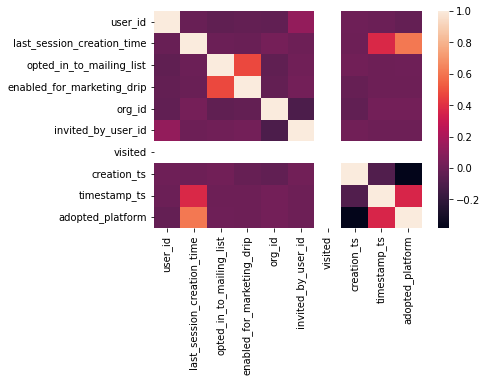

In [43]:
sns.heatmap(df_target_var.corr())

Ok there seems to be some correlation between the features and our target but one thing that we can really see are the correlation between categorical variables I think a bar graph should give us a little better insight.

<AxesSubplot:xlabel='adopted_platform'>

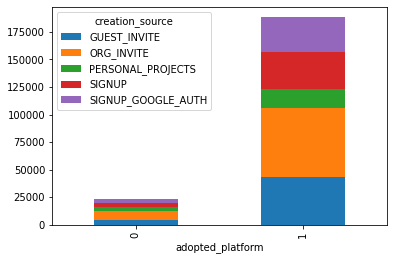

In [85]:
df_plot = df_target_var.groupby(['creation_source', 'adopted_platform']).size().reset_index().pivot(columns='creation_source', index='adopted_platform', values=0)
df_plot.plot(kind='bar', stacked=True)

In [45]:
df_target_var['org_id'].nunique()

417

In [47]:
df_by_org = df_target_var.loc[df_target_var['adopted_platform'] == 1, ['org_id', 'adopted_platform']].groupby(by=['org_id']).sum().reset_index()

In [48]:
df_by_org.head()

,org_id,adopted_platform
0,0,980
1,1,2056
2,2,1769
3,3,1700
4,4,1834


In [49]:
df_by_org.sort_values(by=['adopted_platform'], ascending=False).head()

,org_id,adopted_platform
1,1,2056
13,13,2012
61,62,1959
4,4,1834
2,2,1769


In [50]:
df_by_org['adopted_platform'].describe()

count     372.000000
mean      506.013441
std       394.370599
min        12.000000
25%       193.000000
50%       415.000000
75%       715.500000
max      2056.000000
Name: adopted_platform, dtype: float64

Intersting insight it appears that all across the board for the various sign-up sources the adopted users is most by those from an org invite. That makes sense because if the org invites you to a platform its usually for work purposes and you will most liekly find yourself using it. However, even there the conversion percentage (in comparison to its counterparts significantly higher) is still kind of low. Still we aren't interested in why the conversion rates are low for this problem we want to know what were the contributing factors that leads to conversion rates. Let's continue.

<AxesSubplot:xlabel='adopted_platform'>

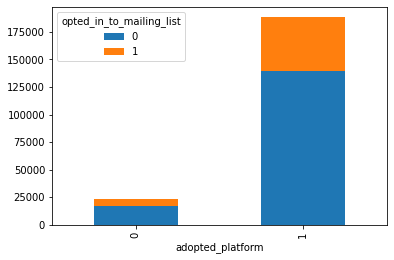

In [55]:
df_plot = df_target_var.groupby(['opted_in_to_mailing_list', 'adopted_platform']).size().reset_index().pivot(columns='opted_in_to_mailing_list', index='adopted_platform', values=0)
df_plot.plot(kind='bar', stacked=True)
# _ = sns.countplot(x='opted_in_to_mailing_list', data=df_target_var, hue='adopted_platform')
# _ = plt.xticks(rotation=90)

<AxesSubplot:xlabel='adopted_platform'>

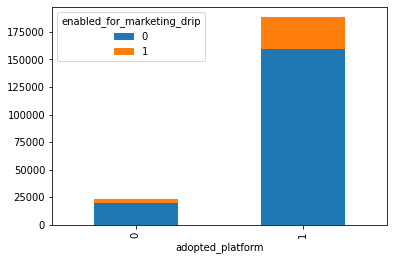

In [78]:
df_plot = df_target_var.groupby(['enabled_for_marketing_drip', 'adopted_platform']).size().reset_index().pivot(columns='enabled_for_marketing_drip', index='adopted_platform', values=0)
df_plot.plot(kind='bar', stacked=True)
# _ = sns.countplot(x='enabled_for_marketing_drip', data=df_target_var, hue='adopted_platform')
# _ = plt.xticks(rotation=90)

This is intersting it appears that for some of these features its hard to tell the percentage difference between the two groups, but one thing is certain that from a value perspective both groups that opted to be in the mailing list as well as enabled for marketing drop are indicators of more people getting adopted. Let's see if that holds up porportionally.

Sidenote - I want to see something about people with no invite id assocaited with their name if they overlap with people who signed up for themselves. I think we can verify with a t-test :)!!

In [69]:
df_target_var['last_session_creation_time'].fillna(-1, inplace=True)
stats.ttest_ind(df_target_var.loc[df_target_var['creation_source'].isin(['SIGNUP', 'SIGNUP_GOOGLE_AUTH', 'PERSONAL_PROJECTS']), 'last_session_creation_time'],df_target_var.loc[df_target_var['invited_by_user_id'] == -1, 'last_session_creation_time'])

Ttest_indResult(statistic=0.0, pvalue=1.0)

Fantastic we can confirm that these two groups are the same with the p value being one. Essentially there is no difference between the two.

In [70]:
df_target_var.isna().sum().sort_values(ascending=False)

visited                       3177
user_id                          0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id               0
creation_ts                      0
timestamp_ts                     0
adopted_platform                 0
dtype: int64

Sidenote - Let's do one more comparison between those who visited and those who did not or the ones responses were recorded regarding their conversion rates.

In [71]:
df_target_var['visited'].unique()

array([ 1., nan])

In [72]:
df_target_var['visited'].fillna(0)

login_day
2014-04-22 03:53:30    1.0
2013-11-15 03:45:04    1.0
2013-11-29 03:45:04    1.0
2013-12-09 03:45:04    1.0
2013-12-25 03:45:04    1.0
                      ... 
2013-09-06 06:14:15    1.0
2013-01-15 18:28:37    1.0
2014-04-27 12:45:16    1.0
2012-06-02 11:55:59    1.0
2014-01-26 08:57:12    1.0
Name: visited, Length: 211094, dtype: float64

<AxesSubplot:xlabel='adopted_platform'>

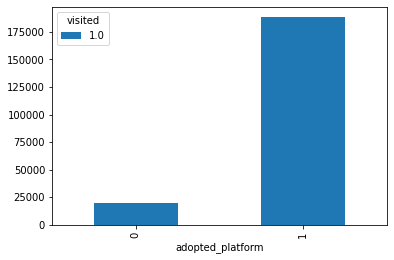

In [73]:
df_plot = df_target_var.groupby(['visited', 'adopted_platform']).size().reset_index().pivot(columns='visited', index='adopted_platform', values=0)
df_plot.plot(kind='bar', stacked=True)

Ok interesting it seems that a heavy indicator of whether the user converted seems to be related to the them visited or not. I'm not sure if this is something we can rely on because of the fact we have about users who have been classified as adopted the platforms (not unique by the way). I think this may be a red flag just for another flag that we saw that the users that did not visit weren't designated as a zero but actually designated as a null value. I will go ahead and drop this column.

In [74]:
df_target_var.drop(columns=['visited'], inplace=True)

In [75]:
df_target_var.isna().sum().sort_values(ascending=False)

user_id                       0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
creation_ts                   0
timestamp_ts                  0
adopted_platform              0
dtype: int64

In [76]:
df_target_var.shape

(211094, 10)